In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from Bio.Seq import Seq
from Bio import SeqIO
import os 
from sklearn import metrics
# 读取 CSV 文件
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import os,sys
import numpy as np
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
warnings.filterwarnings("ignore")

In [2]:
huggingface_calm =  pd.read_pickle("/hpcfs/fhome/yangchh/workdir/self/TLCP-EPE/test/test_data/embeddings-nofinetuned/huggingface_calm.pkl")
t5 =  pd.read_pickle("/hpcfs/fhome/yangchh/workdir/self/TLCP-EPE/test/test_data/embeddings-nofinetuned/prot_t5_xl_uniref50.pkl")

def cancat_codon_protein_representation(df1,df2):
    df = pd.DataFrame(columns=["embedding","labels"])
    for i in range(len(df1)):
        df.loc[i,"embedding"] = np.hstack( (df1.loc[i,"embedding"], df2.loc[i,"embedding"]) )
        df.loc[i,"labels"] = df1.loc[i,"labels"]
    return df
Calm_t5 =  cancat_codon_protein_representation(huggingface_calm, t5)

In [3]:
embedding_basedir = "/hpcfs/fhome/yangchh/workdir/self/TLCP-EPE/test/test_data/embeddings-nofinetuned"
Calm_t5.to_pickle(os.path.join( embedding_basedir, "Finetune_CaLM+ProtT5.pkl" ))

In [2]:
def fasta_to_dataframe(fasta_path):
    """
    Convert a FASTA file to a pandas DataFrame.
    
    Args:
        fasta_path (str): Path to the FASTA file
        
    Returns:
        pd.DataFrame: DataFrame with columns ['id', 'description', 'sequence']
    """
    # Initialize lists to store the data
    records = []
    
    # Parse the FASTA file
    with open(fasta_path, 'r') as handle:
        for record in SeqIO.parse(handle, 'fasta'):
            records.append({
                'id': record.id,
                'sequence': str(record.seq)
            })
    
    # Convert to DataFrame
    df = pd.DataFrame(records)
    return df

In [4]:
import pandas as pd
import json

def load_and_process_metrics(json_path, metrics=["eval_auc", "eval_accuracy","eval_f1"], keep_columns=["Mean"]):
    """
    读取 JSON 文件并将其转换为 DataFrame，将索引作为一列并重命名指标。

    参数：
        json_path (str): JSON 文件的路径
        metrics (list): 要保留的指标列表（默认: ["eval_auc", "eval_accuracy", "eval_f1"]）
        keep_columns (list): 要保留的列名列表（默认: ["Mean"]）

    返回：
        pandas.DataFrame: 处理后的 DataFrame，包含 Metric 列和指定列，指标重命名
    """
    # 读取 JSON 文件
    with open(json_path, 'r') as f:
        data = json.load(f)

    # 将 JSON 数据转换为 DataFrame
    df = pd.DataFrame({
        metric: values for metric, values in data.items()
    }).T  # 转置使指标名称成为索引

    # 重命名列名
    df.columns = ['Mean', 'Std', 'Min', 'Max']

    # 仅保留指定指标
    df = df.loc[metrics]

    # 将索引重置为列
    df = df.reset_index().rename(columns={'index': 'Metric'})

    # 重命名指标
    metric_mapping = {
        'eval_auc': 'AUC',
        'eval_accuracy': 'ACC',
        # 'eval_precision': 'Precision',
        # 'eval_recall': 'Recall',
        'eval_f1': 'F1'
        
    }
    df['Metric'] = df['Metric'].map(metric_mapping)

    # 保留指定列
    df = df[['Metric'] + keep_columns]

    return df

t5_lora_json_path = '/hpcfs/fhome/yangchh/workdir/self/TLCP-EPE/data/output/saved_models_prot_t5_xl_uniref50_lora_fold_10/cross_validation_results.json'
t5_freeze_json_path = '/hpcfs/fhome/yangchh/workdir/self/TLCP-EPE/data/output/saved_models_prot_t5_xl_uniref50_freeze_fold_10/cross_validation_results.json'
t5_full_json_path = '/hpcfs/fhome/yangchh/workdir/self/TLCP-EPE/data/output/saved_models_prot_t5_xl_uniref50_full_fold_10/cross_validation_results.json'
t5_shallow_json_path = '/hpcfs/fhome/yangchh/workdir/self/TLCP-EPE/data/output/saved_models_prot_t5_xl_uniref50_shallow_fold_10/cross_validation_results.json'
t5_deep_json_path = '/hpcfs/fhome/yangchh/workdir/self/TLCP-EPE/data/output/saved_models_prot_t5_xl_uniref50_deep_fold_10/cross_validation_results.json'


t5_lora_df = load_and_process_metrics(t5_lora_json_path, keep_columns=["Mean"])
t5_freeze_df = load_and_process_metrics(t5_freeze_json_path, keep_columns=["Mean"])
t5_full_df = load_and_process_metrics(t5_full_json_path, keep_columns=["Mean"])
t5_shallow_df = load_and_process_metrics(t5_shallow_json_path, keep_columns=["Mean"])
t5_deep_df = load_and_process_metrics(t5_deep_json_path, keep_columns=["Mean"])

t5_freeze_df["Method"]="Frozen"
t5_lora_df["Method"] = "LoRA"
t5_full_df["Method"] = "Full"
t5_shallow_df["Method"] = "Shallow"
t5_deep_df["Method"] = "Deep"
t5 = pd.concat([t5_lora_df, t5_deep_df, t5_freeze_df, t5_shallow_df, t5_full_df])


calm_lora_json_path = '/hpcfs/fhome/yangchh/workdir/self/TLCP-EPE/data/output/saved_models_huggingface_calm_lora_fold_10/cross_validation_results.json'
calm_freeze_json_path = '/hpcfs/fhome/yangchh/workdir/self/TLCP-EPE/data/output/saved_models_huggingface_calm_freeze_fold_10/cross_validation_results.json'
calm_full_json_path = '/hpcfs/fhome/yangchh/workdir/self/TLCP-EPE/data/output/saved_models_huggingface_calm_full_fold_10/cross_validation_results.json'

calm_shallow_json_path = '/hpcfs/fhome/yangchh/workdir/self/TLCP-EPE/data/output/saved_models_huggingface_calm_shallow_fold_10/cross_validation_results.json'
calm_deep_json_path = '/hpcfs/fhome/yangchh/workdir/self/TLCP-EPE/data/output/saved_models_huggingface_calm_deep_fold_10/cross_validation_results.json'
calm_lora_df = load_and_process_metrics(calm_lora_json_path, keep_columns=["Mean"])
calm_freeze_df = load_and_process_metrics(calm_freeze_json_path, keep_columns=["Mean"])
calm_full_df = load_and_process_metrics(calm_full_json_path, keep_columns=["Mean"])
calm_shallow_df = load_and_process_metrics(calm_shallow_json_path, keep_columns=["Mean"])
calm_deep_df = load_and_process_metrics(calm_deep_json_path, keep_columns=["Mean"])

calm_freeze_df["Method"]="Frozen"
calm_lora_df["Method"] = "LoRA"
calm_full_df["Method"] = "Full"
calm_shallow_df["Method"] = "Shallow"
calm_deep_df["Method"] = "Deep"

calm = pd.concat([calm_lora_df, calm_deep_df, calm_freeze_df, calm_shallow_df, calm_full_df])

In [5]:
t5

,Metric,Mean,Method
0,AUC,0.763262,LoRA
1,ACC,0.698002,LoRA
2,F1,0.661335,LoRA
0,AUC,0.763338,Deep
1,ACC,0.685726,Deep
2,F1,0.633259,Deep
0,AUC,0.752304,Frozen
1,ACC,0.682822,Frozen
2,F1,0.639847,Frozen
0,AUC,0.735425,Shallow


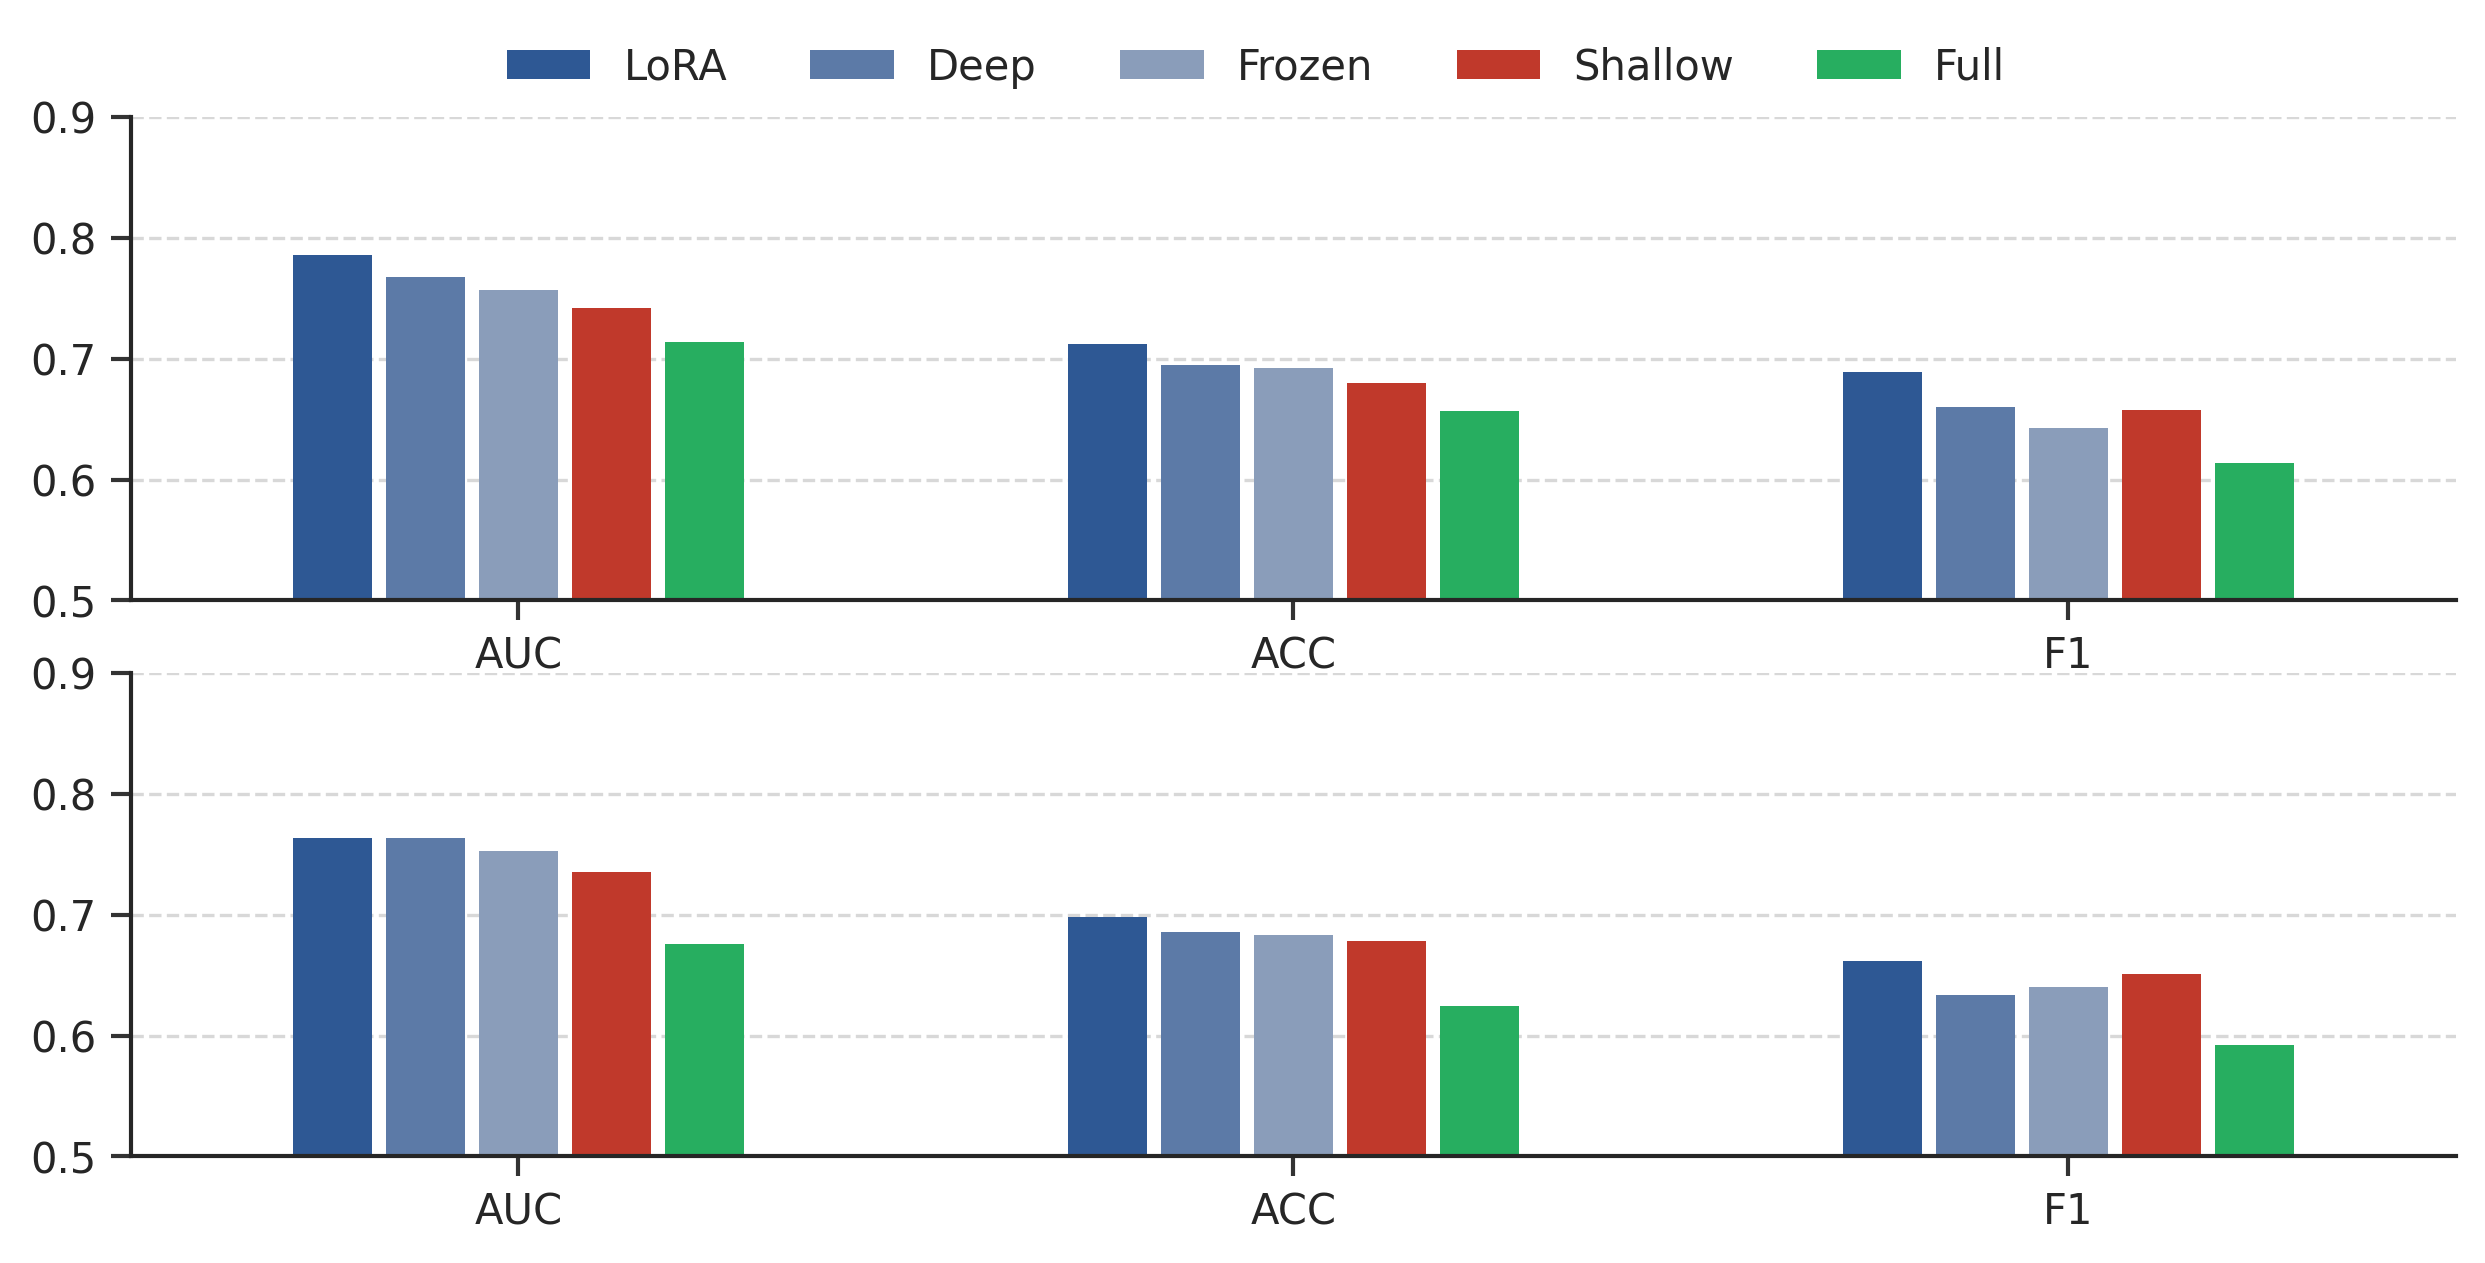

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import numpy as np
from matplotlib.patches import Rectangle
import pandas as pd

# 设置出版级样式
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
sns.set_theme(style="ticks", context="paper")

# ✅ 自定义 5 色调色板
custom_palette = [
    '#2E5894',  # Deep Blue
    '#5C7AA7',  # Light Steel Blue
    '#8A9DBA',  # Silver Blue
    '#C0392B',  # Red
    '#27AE60'   # Green
]

# 示例数据
df1 = calm  # CalM-I
df2 = t5  # CalM-II

# ✅ 只保留 AUC, ACC, F1
metrics_order = ['AUC', 'ACC', 'F1']
df1 = df1[df1['Metric'].isin(metrics_order)].copy()
df2 = df2[df2['Metric'].isin(metrics_order)].copy()

# 保证 x 轴顺序
df1['Metric'] = pd.Categorical(df1['Metric'], categories=metrics_order, ordered=True)
df2['Metric'] = pd.Categorical(df2['Metric'], categories=metrics_order, ordered=True)
df1 = df1.sort_values('Metric')
df2 = df2.sort_values('Metric')

# ========== 创建图形：紧凑布局 ==========
fig, (ax1, ax2) = plt.subplots(
    2, 1,
    figsize=(10, 4.5),
    dpi=300,
    gridspec_kw={'height_ratios': [1, 1], 'hspace': 0.15}
)

# ========== 子图 A：CalM-I ==========
bar1 = sns.barplot(
    x="Metric", y="Mean", hue="Method", data=df1,
    palette=custom_palette,
    ax=ax1,
    linewidth=0,        # 无边框
    width=0.6,           # 🔽 减小宽度，为间隙留空间
    saturation=1.0,
    dodge=True,
    gap=0.15            # ✅ 条形之间添加 15% 的间隙（0.15 是相对值）
)

# 添加数值标签
# for container in bar1.containers:
#     ax1.bar_label(container, fmt='%.3f', fontsize=7, padding=1, fontweight='bold')

# 子图标记
# ax1.text(-0.04, 1.08, 'A', transform=ax1.transAxes, fontsize=12, fontweight='bold', va='top')

# 设置 y 轴
ax1.set_ylim(0.5, 0.9)
y_ticks = np.arange(0.5, 1.0, 0.1)
ax1.set_yticks(y_ticks)
ax1.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))

# 刻度和网格
ax1.tick_params(axis='both', labelsize=10, color='#333333')
ax1.grid(True, axis='y', linestyle='--', color='gray', alpha=0.3, linewidth=0.8)
ax1.set_axisbelow(True)

# ✅ 设置 x 轴标签
ax1.set_xlabel("")
ax1.set_ylabel("")
ax1.set_xticklabels(metrics_order, rotation=0)

# ✅ 去掉上边框和右边框
sns.despine(ax=ax1, top=True, right=True)


# ========== 子图 B：CalM-II ==========
bar2 = sns.barplot(
    x="Metric", y="Mean", hue="Method", data=df2,
    palette=custom_palette,
    ax=ax2,
    linewidth=0,        # 无边框
    width=0.6,           # 同样减小
    saturation=1.0,
    dodge=True,
    gap=0.15            # ✅ 添加间隙
)

# for container in bar2.containers:
#     ax2.bar_label(container, fmt='%.3f', fontsize=7, padding=1, fontweight='bold')

# ax2.text(-0.04, 1.08, 'B', transform=ax2.transAxes, fontsize=12, fontweight='bold', va='top')

ax2.set_ylim(0.5, 0.9)
ax2.set_yticks(y_ticks)
ax2.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))

ax2.tick_params(axis='both', labelsize=10, color='#333333')
ax2.grid(True, axis='y', linestyle='--', color='gray', alpha=0.3, linewidth=0.8)
ax2.set_axisbelow(True)

# ✅ 设置 x 轴标签
ax2.set_xlabel("")
ax2.set_ylabel("")
ax2.set_xticklabels(metrics_order, rotation=0)

# ✅ 去掉上边框和右边框
sns.despine(ax=ax2, top=True, right=True)


# ========== 移除子图图例 ==========
ax1.legend().remove()
ax2.legend().remove()

# ========== ✅ 创建条形图风格图例（顶部居中）==========
custom_patches = [
    Rectangle((0, 0), 1, 1, facecolor=custom_palette[i], linewidth=0)
    for i in range(5)
]

_, labels = bar1.get_legend_handles_labels()

fig.legend(
    custom_patches,
    labels,
    loc='upper center',
    ncol=5,
    fontsize=10,
    title_fontsize=11,
    frameon=False,
    bbox_to_anchor=(0.5, 0.96)
)

# ========== 布局调整 ==========
plt.tight_layout(rect=[0, 0.06, 1, 0.94])

# ========== 保存 ==========
plt.savefig("calm_barplot_final_with_gap.pdf", dpi=300, bbox_inches='tight')
plt.savefig("calm_barplot_final_with_gap.png", dpi=300, bbox_inches='tight')

plt.show()